In [ ]:
# installing mplsoccer
!pip install mplsoccer

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch, Sbopen

### Opening the dataset

We get all games England Women's played - as home or as away team

In [4]:
# opening the data
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)

# getting a team
team = "England Women's"

# getting list of games by our team, either home or away
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()

# calculating the number of games
no_games = len(match_ids)

### Finding danger passes

In [5]:
# declaring an empty dataframe
danger_passes = pd.DataFrame()

for idx in match_ids:

    # opening the event data from this game
    df = parser.event(idx)[0]
    for period in [1, 2]:

        # keeping only accurate passes by England that were not set pieces in this period
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())

        # keeping only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]

        # keeping only Shots by England in this period
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)

        # keeping only necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]

        # converting time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15

        # finding starts of the window
        shot_start = shot_times - shot_window

        # condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)

        # converting to seconds
        pass_times = passes['minute']*60+passes['second']

        # checking if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        # keeping only danger passes
        danger_passes_period = passes.loc[pass_to_shot]

        # concatenating dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

### Plotting location of danger passes

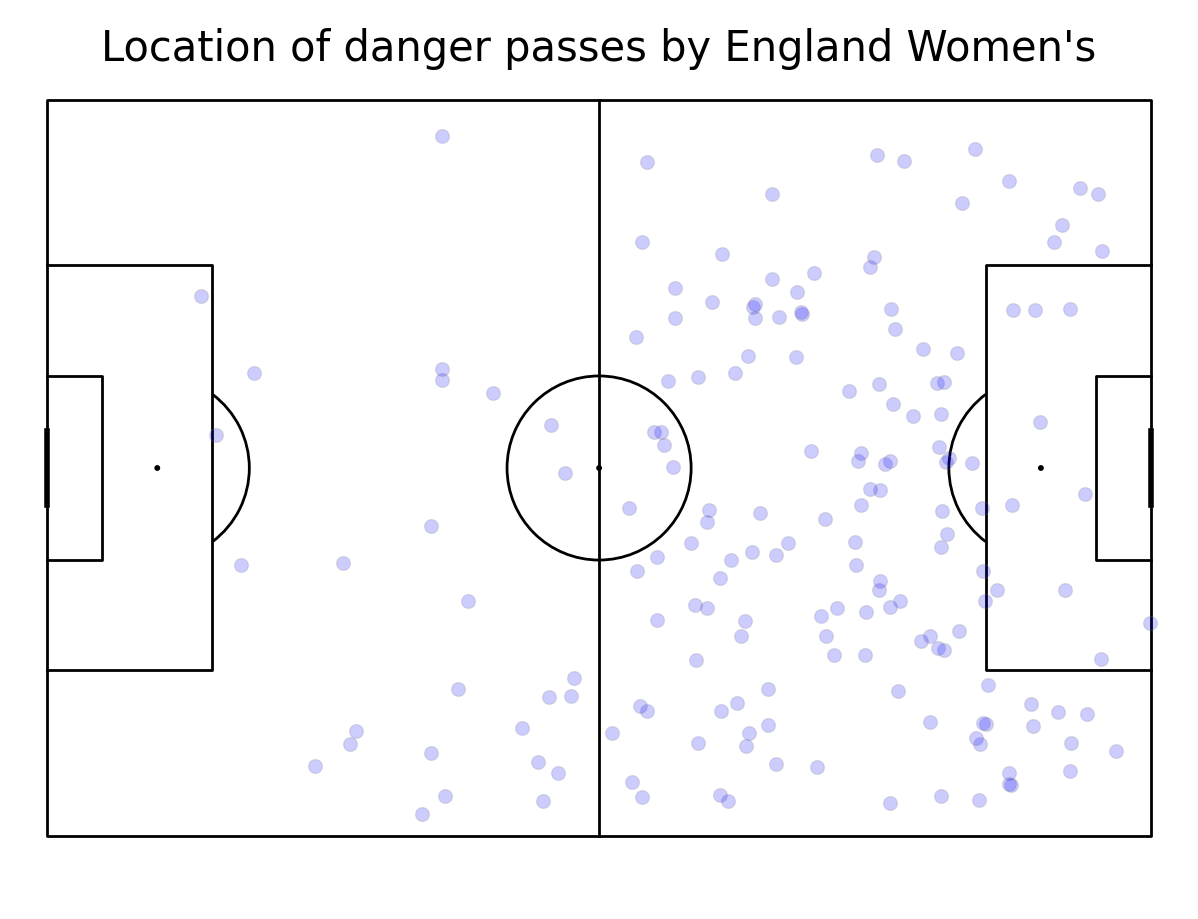

In [7]:
# plotting pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# scattering the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])

# adding arrows if needed
# pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])

# adding title
fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()

### Making a heat map

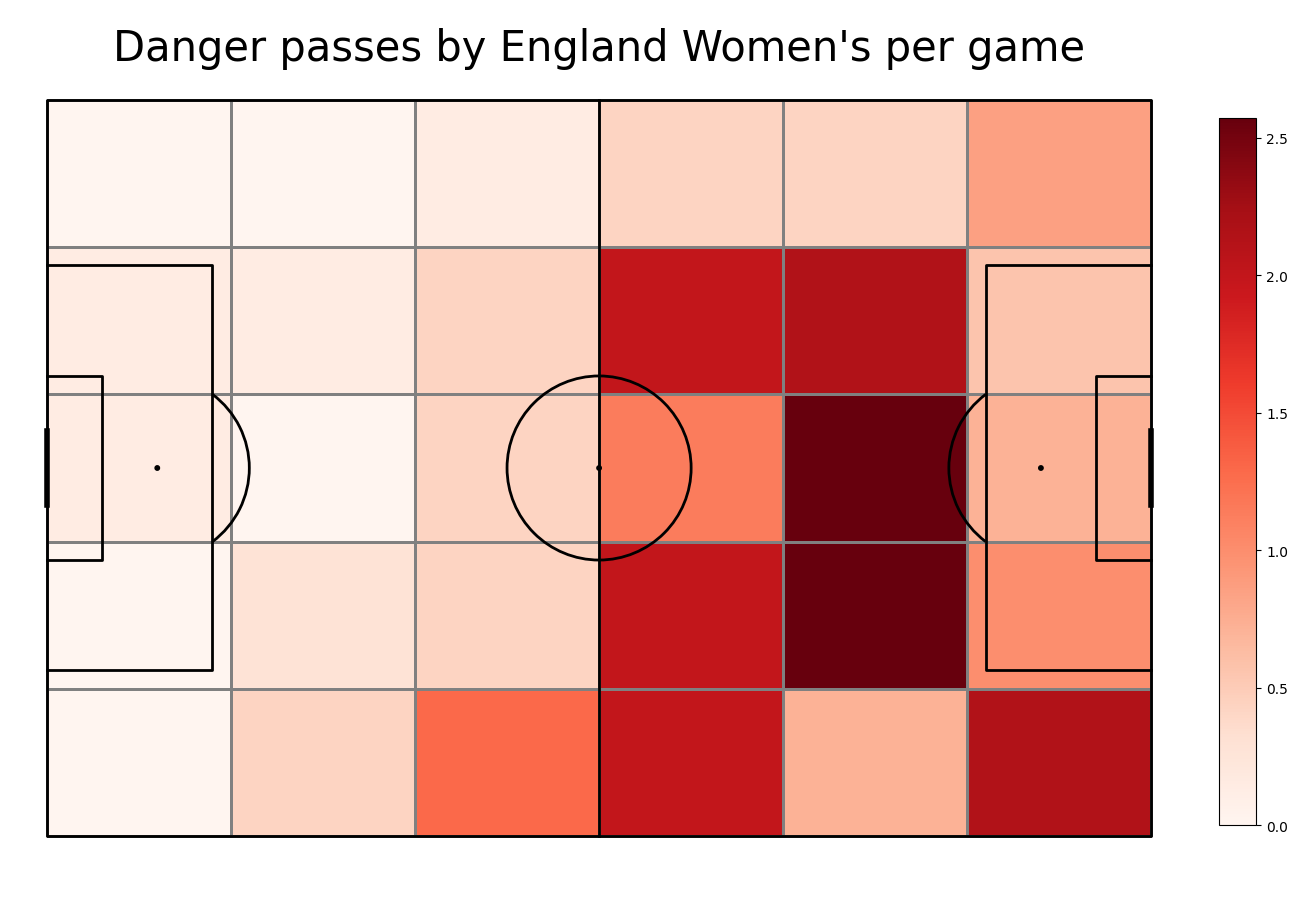

In [8]:
# plotting vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# getting the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)

# normalizing by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games

# making a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

### Making a diagram of most involved players

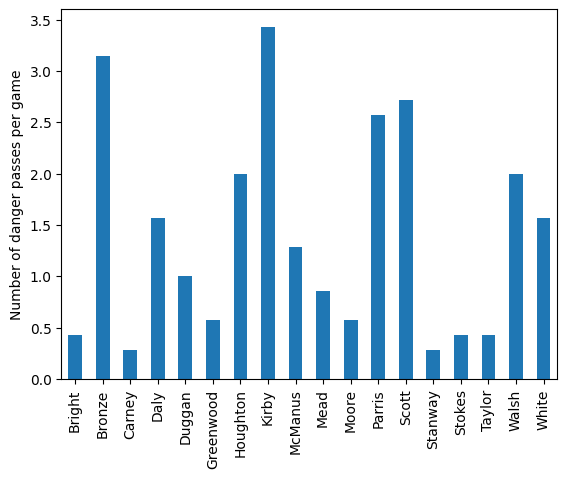

In [9]:
# keeping only surnames
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])

# counting passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games

# making a histogram
ax = pass_count.plot.bar(pass_count)

# making legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()